<a href="https://colab.research.google.com/github/manujism/Nilesh-Client-Simulations/blob/main/Pune_House_Loan_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- SETUP ---
✅ Client data file: 'Pune House Purchase - Loan 60 lacs.xlsx'
✅ Returns data file: 'Nilesh - Returns.xlsx'
✅ Data loaded and validated.
ℹ️ Using SIP from column: Total Investment (treated as already net of EMI).

--- Running 1,000 simulations for 'Scenario: ₹15L Own Contribution in Oct-2025 + ₹60L Loan (SIP already net of EMI)' ---


########################################################################################################################
###                                   Detailed Monthly Log for a RANDOM Simulation Path                                    ###
########################################################################################################################
           Date Withdrawal Liquid_Corpus Total_Corpus Debt_Value Flexi Cap Funds_Value Gold_Value Gurugram_Plot1_Value Gurugram_Plot2_Value Large Cap Index_Value Nagpur_Property_Value Pune_Home_2030_Value Pune_Property_Value Real_Estate_Other_Value Debt_Allocation_% Flexi Cap Fund

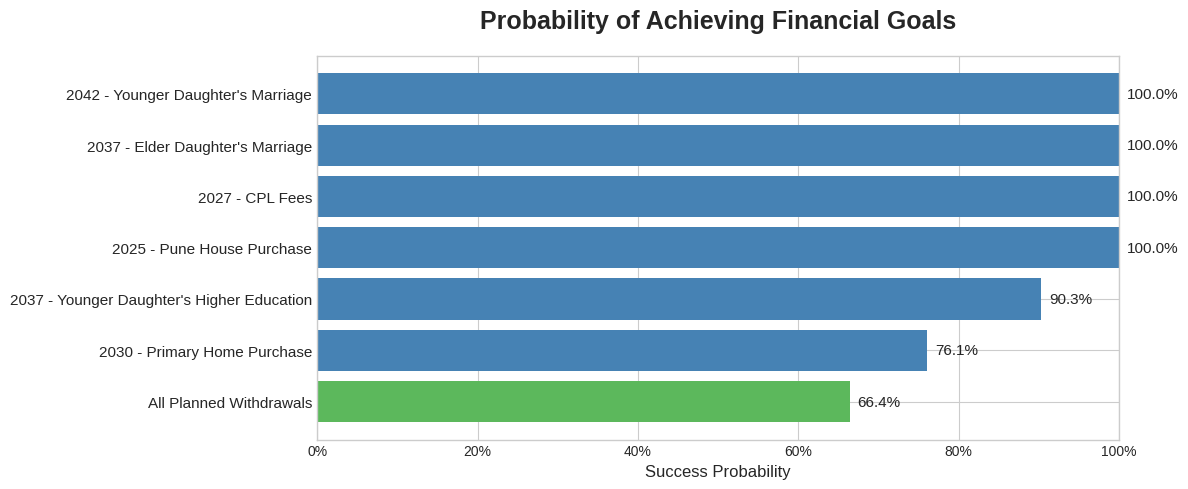

/tmp/ipython-input-1703903369.py:357: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


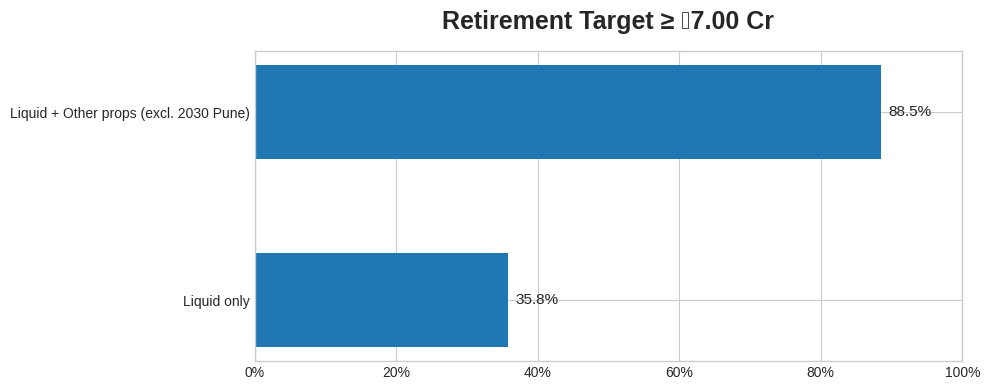

/tmp/ipython-input-1703903369.py:390: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


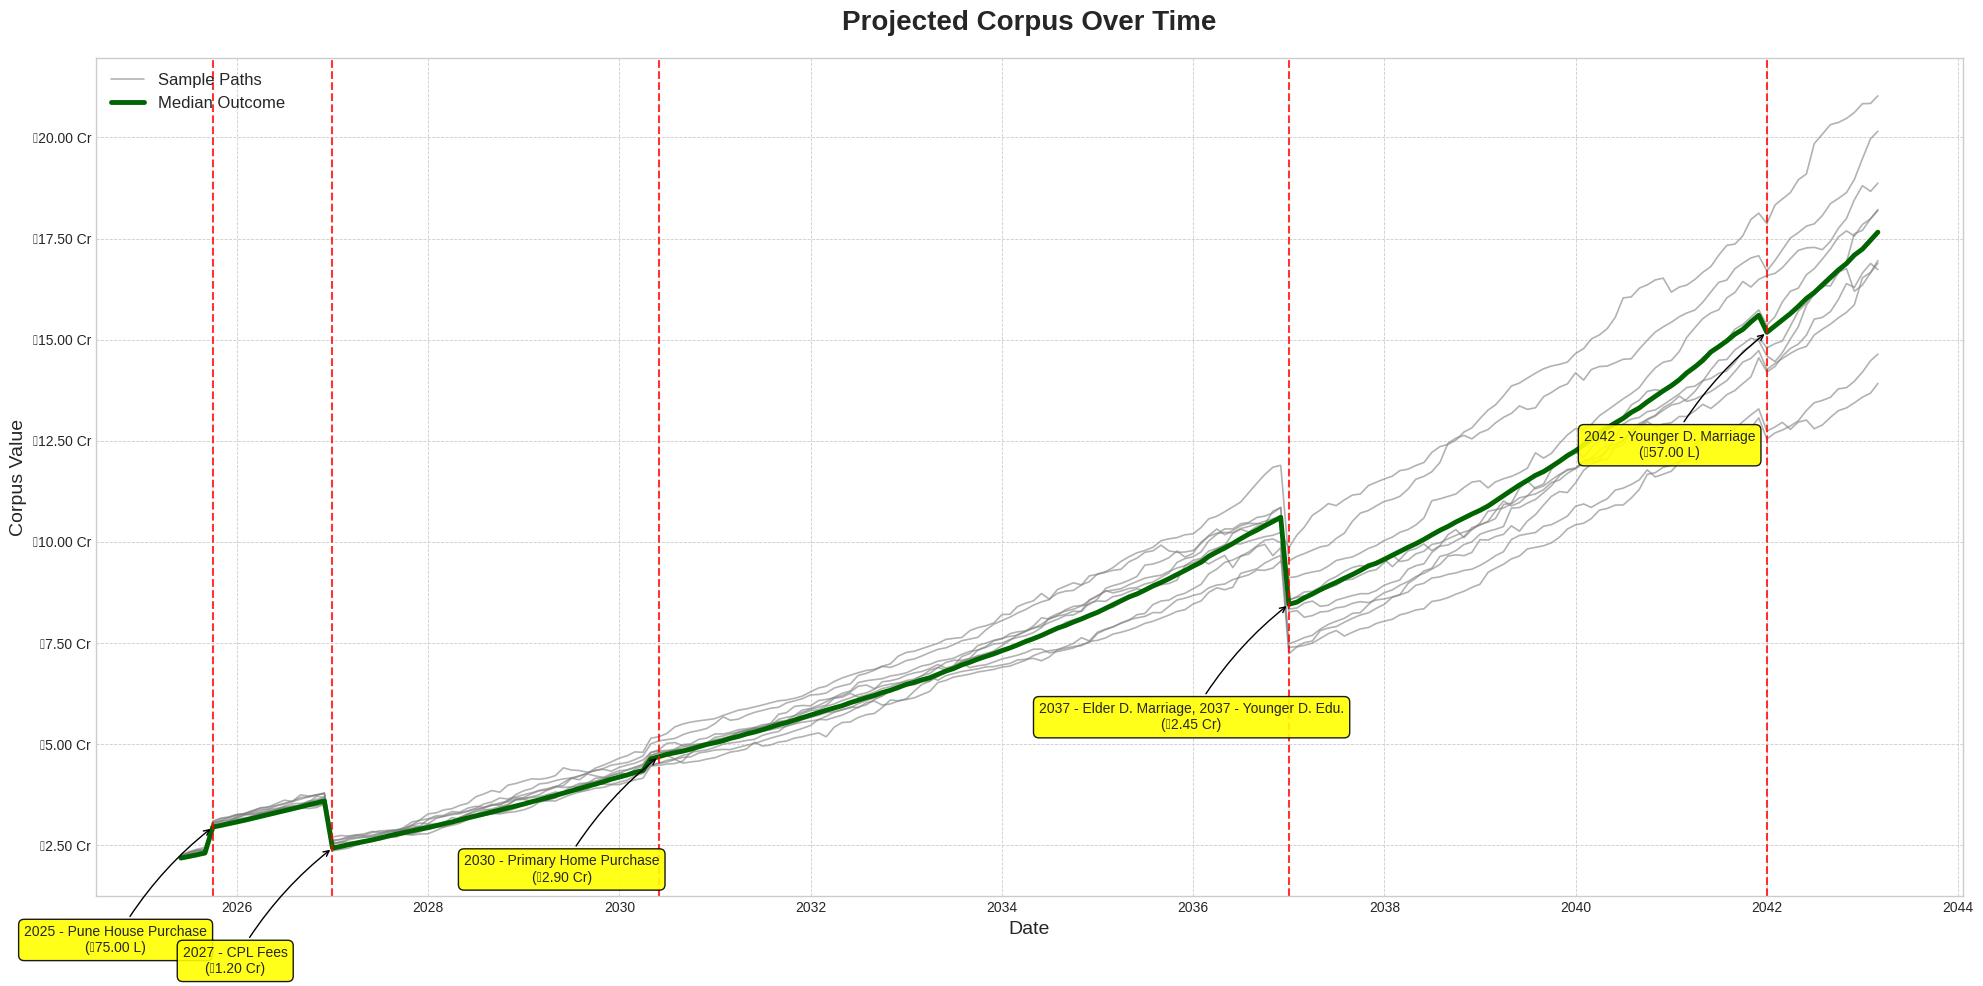

/tmp/ipython-input-1703903369.py:410: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


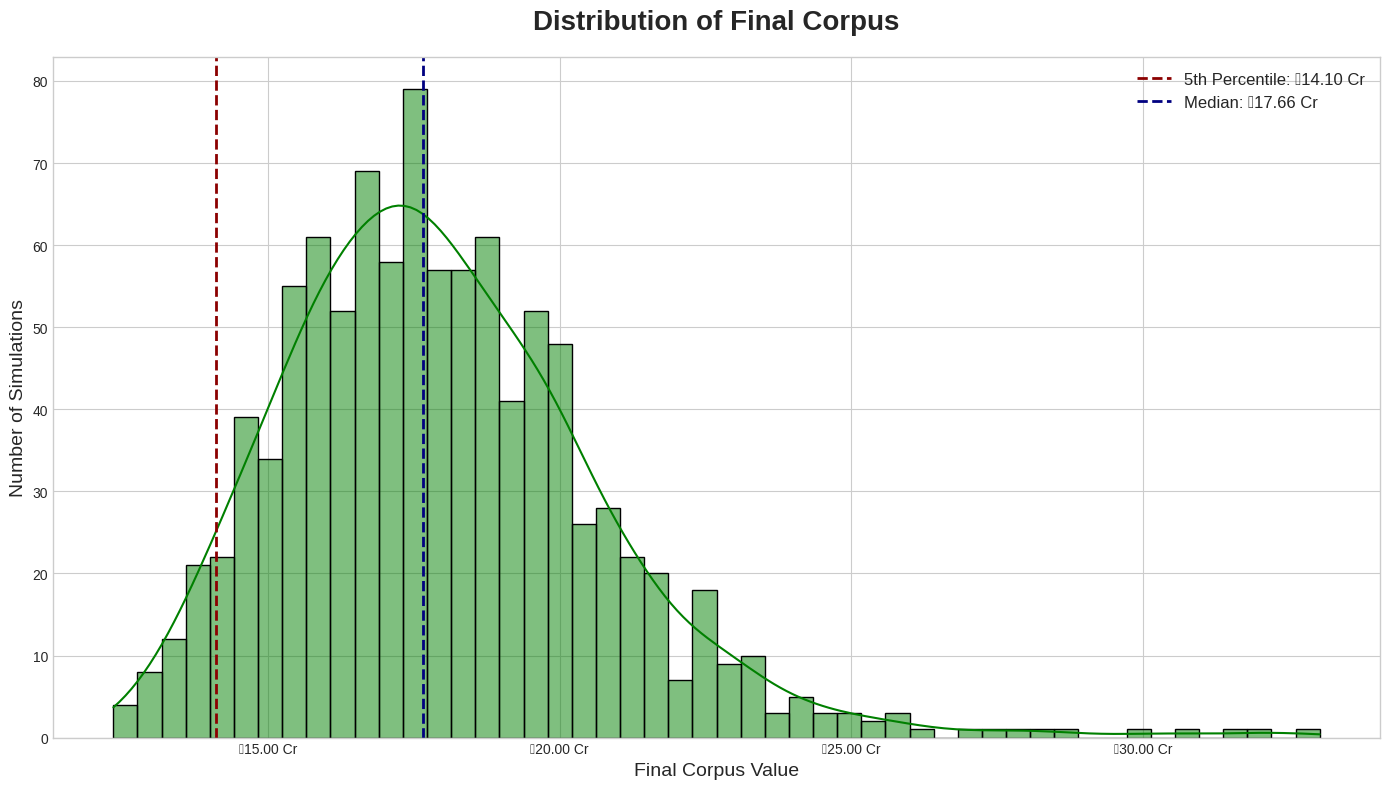


✅ All analyses complete.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from collections import Counter
import os

# --- FIX FOR THE RUPEE SYMBOL (₹) ---
from matplotlib.font_manager import fontManager
import urllib.request

try:
    font_url = 'https://github.com/google/fonts/raw/main/ofl/lohitdevanari/Lohit-Devanagari.ttf'
    font_filename = 'Lohit-Devanagari.ttf'
    if not any(font.fname.endswith(font_filename) for font in fontManager.ttflist):
        urllib.request.urlretrieve(font_url, font_filename)
        fontManager.addfont(font_filename)
    plt.rcParams['font.family'] = 'Lohit Devanagari'
except Exception:
    pass
# --- END OF FIX BLOCK ---


# --- Helpers ---
def format_indian_currency(num):
    """Converts a number to a string in Indian Crores/Lakhs format."""
    if pd.isna(num) or num == 0:
        return "₹0 L"
    num = float(num)
    sign = "(-)" if num < 0 else ""
    num = abs(num)
    if num >= 1_00_00_000:
        return f"{sign}₹{num / 1_00_00_000:,.2f} Cr"
    else:
        return f"{sign}₹{num / 1_00_000:,.2f} L"


def pick_col(df, *candidates, required=False):
    """Return the first matching column name (case-insensitive) from candidates."""
    lookup = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lookup:
            return lookup[cand.lower()]
    if required:
        raise KeyError(f"None of the expected columns found: {candidates}")
    return None


def copy_amount_from_excel_on(dates_indexed_df, goal_df, excel_col, goal_name, date_str):
    """Copy a number from an Excel column into goal_df on a specific date (as a side column)."""
    if dates_indexed_df is None or excel_col not in dates_indexed_df.columns:
        return
    d = pd.to_datetime(date_str)
    if d in goal_df.index and d in dates_indexed_df.index:
        val = dates_indexed_df.loc[d, excel_col]
        if pd.notna(val) and float(val) > 0:
            if excel_col not in goal_df.columns:
                goal_df[excel_col] = 0.0
            goal_df.loc[d, excel_col] = float(val)


# --- Monte Carlo Simulation Engine ---
def run_simulation(
    name,
    initial_corpus_weights,
    sip_weights,
    initial_investment,
    sip_schedule,
    goal_df,
    returns_df,
    num_simulations,
    dates,
    client_data_df_indexed=None,
):
    """
    Runs a full, multi-path simulation.

    Assumptions / scenario notes:
      • SIP in Excel is ALREADY net of EMI. We don't touch EMI at all.
      • Oct-2025 purchase: withdraw ONLY the own contribution (default ₹15L, or from Excel if provided),
        but book the FULL property price to Pune_Property (loan funds the rest implicitly).
      • 2030 home is tracked separately as 'Pune_Home_2030' so we can exclude it from the second retirement metric.
    """
    print(f"\n--- Running {num_simulations:,} simulations for '{name}' ---")

    investment_horizon_months = len(sip_schedule)
    goal_columns = goal_df.columns

    base_assets = sorted(list(set(initial_corpus_weights.keys()) | set(sip_weights.keys())))
    all_asset_components = base_assets.copy()
    if 'Real Estate' in all_asset_components:
        all_asset_components.remove('Real Estate')
        all_asset_components.extend(['Real_Estate_Other', 'Gurugram_Plot1', 'Gurugram_Plot2', 'Pune_Property', 'Nagpur_Property'])
    all_asset_components.append('Pune_Home_2030')  # track 2030 home separately
    all_asset_components = sorted(all_asset_components)

    corpus_over_time_all_sims = np.zeros((num_simulations, investment_horizon_months))
    final_corpus_values = []
    final_liquid_corpus_values = []
    final_liquid_plus_other_values = []  # liquid + other props (exclude 2030 home)
    goal_failure_counter = Counter()
    liquidity_failures = 0

    simulation_to_log = np.random.randint(0, num_simulations)
    detailed_log_for_one_sim = []

    for i in range(num_simulations):
        # --- Initialize portfolio ---
        corpus_by_asset = {}
        for asset, weight in initial_corpus_weights.items():
            corpus_by_asset[asset] = initial_investment * weight

        # Split initial real estate bucket
        gurugram_plot1_initial = 25_00_000
        gurugram_plot2_initial = 40_00_000
        total_initial_re = corpus_by_asset.get('Real Estate', 0)
        corpus_by_asset['Gurugram_Plot1'] = gurugram_plot1_initial
        corpus_by_asset['Gurugram_Plot2'] = gurugram_plot2_initial
        corpus_by_asset['Real_Estate_Other'] = total_initial_re - (gurugram_plot1_initial + gurugram_plot2_initial)
        corpus_by_asset['Pune_Property'] = 0
        corpus_by_asset['Nagpur_Property'] = 0
        corpus_by_asset['Pune_Home_2030'] = 0  # init
        if 'Real Estate' in corpus_by_asset:
            del corpus_by_asset['Real Estate']

        gurugram_sale_proceeds_in_debt = 0
        has_failed_this_sim = False

        for month in range(investment_horizon_months):
            current_date = dates.iloc[month]
            sip_this_month = sip_schedule[month]

            liquid_assets = ['Debt', 'Flexi Cap Funds', 'Large Cap Index', 'Gold']
            liquid_corpus = sum(corpus_by_asset.get(asset, 0) for asset in liquid_assets)
            liquid_corpus_for_log = liquid_corpus

            # --- GOALS ---
            is_pune_purchase_month_2025 = (current_date.year == 2025 and current_date.month == 10)
            is_pune_purchase_month_2030 = (current_date.year == 2030 and current_date.month == 6)
            general_withdrawal_amount = goal_df.iloc[month].sum()

            # 1) 2025 Pune House (only own contribution taken from liquid; book full price)
            if is_pune_purchase_month_2025:
                pune_house_price = goal_df.loc[current_date, '2025 - Pune House Purchase']

                # default own contribution = ₹15L; allow override via Excel column(s) if present
                own_contribution = 15_00_000.0
                possible_cols = ['Own Contribution', 'Own Contribution (Pune 2025)', 'Pune 2025 Own Contribution']

                for col in possible_cols:
                    if col in goal_df.columns:
                        val = goal_df.loc[current_date, col]
                        if pd.notna(val) and float(val) > 0:
                            own_contribution = float(val)
                            break

                if client_data_df_indexed is not None and current_date in client_data_df_indexed.index:
                    for col in possible_cols:
                        if col in client_data_df_indexed.columns:
                            val = client_data_df_indexed.loc[current_date, col]
                            if pd.notna(val) and float(val) > 0:
                                own_contribution = float(val)
                                break

                needed_from_liquid = min(own_contribution, float(pune_house_price))
                if liquid_corpus >= needed_from_liquid:
                    reduction = (liquid_corpus - needed_from_liquid) / liquid_corpus if liquid_corpus > 0 else 0
                    for asset in liquid_assets:
                        corpus_by_asset[asset] *= reduction
                    # Book full property value; loan covers rest implicitly
                    corpus_by_asset['Pune_Property'] = corpus_by_asset.get('Pune_Property', 0) + float(pune_house_price)
                else:
                    goal_failure_counter.update(['2025 - Pune House Purchase'])
                    if not has_failed_this_sim:
                        liquidity_failures += 1
                    has_failed_this_sim = True

            # 2) 2030 Primary Home (assume full cash withdrawal)
            elif is_pune_purchase_month_2030:
                pune_plot_price = goal_df.loc[current_date, '2030 - Primary Home Purchase']
                if liquid_corpus >= pune_plot_price:
                    gurugram_sale_proceeds_in_debt -= min(pune_plot_price, gurugram_sale_proceeds_in_debt)
                    reduction = (liquid_corpus - pune_plot_price) / liquid_corpus if liquid_corpus > 0 else 0
                    for asset in liquid_assets:
                        corpus_by_asset[asset] *= reduction
                    corpus_by_asset['Pune_Home_2030'] = corpus_by_asset.get('Pune_Home_2030', 0) + float(pune_plot_price)
                else:
                    goal_failure_counter.update(['2030 - Primary Home Purchase'])
                    if not has_failed_this_sim:
                        liquidity_failures += 1
                    has_failed_this_sim = True

            # 3) Regular monthly goals — handle each goal separately if multiple collide
            elif general_withdrawal_amount > 0:
                # Process goals present on this date one-by-one, reducing liquid each time.
                # This ensures success/failure is tracked PER GOAL (e.g., Marriage vs. Education in the same month).
                goals_today = [(goal, goal_df.iloc[month][goal]) for goal in goal_columns if goal_df.iloc[month][goal] > 0]

                # Use the existing column order (already sorted earlier) to avoid arbitrary bias
                for goal_name, amt in goals_today:
                    # Recompute liquid after any prior deductions this month
                    liquid_corpus = sum(corpus_by_asset.get(asset, 0) for asset in liquid_assets)
                    if liquid_corpus >= amt:
                        reduction = (liquid_corpus - amt) / liquid_corpus if liquid_corpus > 0 else 0
                        for asset in liquid_assets:
                            corpus_by_asset[asset] *= reduction
                    else:
                        # Fail ONLY this goal; do NOT automatically fail other goals in the same month
                        goal_failure_counter.update([goal_name])
                        if not has_failed_this_sim:
                            liquidity_failures += 1
                        has_failed_this_sim = True
                        # No partial withdrawal; move on to the next goal (if any)

            # --- SIP INFLOWS (SIP already net of EMI in your Excel) ---
            if sip_this_month > 0:
                for asset, weight in sip_weights.items():
                    corpus_by_asset[asset] = corpus_by_asset.get(asset, 0) + (sip_this_month * weight)

            # Gurugram plots sold in Jan-2030 -> move proceeds to Debt
            if current_date.year == 2030 and current_date.month == 1:
                gurugram_sale_proceeds_in_debt = corpus_by_asset.get('Gurugram_Plot1', 0) + corpus_by_asset.get('Gurugram_Plot2', 0)
                corpus_by_asset['Debt'] = corpus_by_asset.get('Debt', 0) + gurugram_sale_proceeds_in_debt
                corpus_by_asset['Gurugram_Plot1'] = 0
                corpus_by_asset['Gurugram_Plot2'] = 0

            # --- APPLY MONTHLY RETURNS ---
            random_returns_row = returns_df.sample(1).iloc[0]
            for asset in list(corpus_by_asset.keys()):
                if asset in ['Gurugram_Plot1', 'Gurugram_Plot2']:
                    asset_return = random_returns_row.get('Gurugram Real Estate', 0)
                elif asset == 'Real_Estate_Other':
                    asset_return = random_returns_row.get('Nagpur Real Estate', 0)
                elif asset == 'Pune_Property':
                    asset_return = random_returns_row.get('Pune Real Estate', 0)
                elif asset == 'Nagpur_Property':
                    asset_return = random_returns_row.get('Nagpur Real Estate', 0)
                elif asset == 'Pune_Home_2030':
                    asset_return = random_returns_row.get('Pune Real Estate', 0)
                else:
                    asset_return = random_returns_row.get(asset, 0)
                corpus_by_asset[asset] *= (1 + float(asset_return) / 100.0)

            # --- LOGGING (one random path) ---
            if i == simulation_to_log:
                total_corpus_after_actions = sum(corpus_by_asset.values())
                log_entry = {
                    'Date': current_date.strftime('%Y-%m-%d'),
                    'Withdrawal': general_withdrawal_amount,
                    'Liquid_Corpus': liquid_corpus_for_log,
                    'Total_Corpus': total_corpus_after_actions,
                }
                for asset in all_asset_components:
                    log_entry[f'{asset}_Value'] = corpus_by_asset.get(asset, 0)
                for asset in all_asset_components:
                    allocation = (corpus_by_asset.get(asset, 0) / total_corpus_after_actions) * 100 if total_corpus_after_actions > 0 else 0
                    log_entry[f'{asset}_Allocation_%'] = allocation
                detailed_log_for_one_sim.append(log_entry)

            corpus_over_time_all_sims[i, month] = sum(corpus_by_asset.values())

        # End-of-path stats
        final_total_corpus = sum(corpus_by_asset.values())
        final_corpus_values.append(max(final_total_corpus, 0))

        # Liquid at end
        liquid_assets = ['Debt', 'Flexi Cap Funds', 'Large Cap Index', 'Gold']
        final_liquid_corpus = sum(corpus_by_asset.get(asset, 0) for asset in liquid_assets)
        final_liquid_corpus_values.append(max(final_liquid_corpus, 0))

        # Liquid + other properties (exclude 2030 primary Pune home)
        other_property_assets = ['Real_Estate_Other', 'Gurugram_Plot1', 'Gurugram_Plot2', 'Nagpur_Property', 'Pune_Property']
        other_props_value = sum(corpus_by_asset.get(a, 0) for a in other_property_assets)
        final_liquid_plus_other_values.append(max(final_liquid_corpus + other_props_value, 0))

    # Display one path
    print("\n\n" + "#" * 120)
    print("###" + " " * 35 + "Detailed Monthly Log for a RANDOM Simulation Path" + " " * 36 + "###")
    print("#" * 120)
    if detailed_log_for_one_sim:
        detailed_df = pd.DataFrame(detailed_log_for_one_sim)
        display_df = detailed_df.copy()
        value_cols = [c for c in display_df.columns if '_Value' in c or 'Corpus' in c or 'Withdrawal' in c]
        for col in value_cols:
            display_df[col] = display_df[col].apply(format_indian_currency)
        alloc_cols = [c for c in display_df.columns if '_Allocation_%' in c]
        for col in alloc_cols:
            display_df[col] = display_df[col].apply(lambda x: f"{x:.2f}%")

        ordered_cols = ['Date', 'Withdrawal', 'Liquid_Corpus', 'Total_Corpus']
        asset_value_cols = sorted([f'{asset}_Value' for asset in all_asset_components])
        asset_alloc_cols = sorted([f'{asset}_Allocation_%' for asset in all_asset_components])
        ordered_cols.extend(asset_value_cols + asset_alloc_cols)

        with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 2500):
            print(display_df[ordered_cols])

    prob_all_goals = 1 - (liquidity_failures / num_simulations)
    goal_success_prob = {
        goal: 1 - (goal_failure_counter.get(goal, 0) / num_simulations)
        for goal in goal_columns if goal_df[goal].sum() > 0
    }
    return {
        'name': name,
        'prob_all_goals': prob_all_goals,
        'median_corpus': np.median(final_corpus_values),
        '5th_percentile_corpus': np.percentile(final_corpus_values, 5),
        'final_corpus_values': final_corpus_values,
        'goal_success_prob': goal_success_prob,
        'raw_corpus_data': corpus_over_time_all_sims,
        'final_liquid_corpus_values': final_liquid_corpus_values,
        'final_liquid_plus_other_values': final_liquid_plus_other_values,
    }


# --- Visuals ---
def plot_goal_probabilities(goal_probs):
    plt.style.use('seaborn-v0_8-whitegrid')
    if not goal_probs:
        return
    items = sorted(goal_probs.items(), key=lambda kv: kv[1])
    labels = [k for k, _ in items]
    probs = [v for _, v in items]

    fig, ax = plt.subplots(figsize=(12, max(5, len(labels) * 0.7)))
    colors = ['#5cb85c' if 'All' in lbl else '#4682B4' for lbl in labels]
    bars = ax.barh(labels, probs, color=colors)
    ax.set_xlim(0, 1)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
    ax.set_title('Probability of Achieving Financial Goals', fontsize=18, weight='bold', pad=20)
    ax.set_xlabel('Success Probability', fontsize=12)
    ax.tick_params(axis='y', labelsize=11)
    for bar in bars:
        w = bar.get_width()
        ax.text(w + 0.01, bar.get_y() + bar.get_height()/2, f'{w:.1%}', ha='left', va='center', fontsize=11)
    plt.tight_layout()
    plt.show()


def plot_retirement_goal_probability_dual(prob_liquid, prob_liquid_plus_other, target_corpus):
    """Two-bar plot comparing retirement target success:
       1) Liquid only
       2) Liquid + other properties (excl. 2030 Pune home)
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 4))
    labels = ['Liquid only', 'Liquid + Other props (excl. 2030 Pune)']
    vals = [prob_liquid, prob_liquid_plus_other]
    bars = ax.barh(labels, vals, height=0.5)
    ax.set_xlim(0, 1)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
    ax.set_title(f'Retirement Target ≥ {format_indian_currency(target_corpus)}', fontsize=18, weight='bold', pad=16)
    for bar in bars:
        w = bar.get_width()
        ax.text(w + 0.01, bar.get_y() + bar.get_height()/2, f'{w:.1%}', ha='left', va='center', fontsize=11)
    plt.tight_layout()
    plt.show()


def plot_corpus_projections(results, dates, goal_df):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(20, 10))
    raw = results['raw_corpus_data']
    p50 = np.percentile(raw, 50, axis=0)
    path_idx = np.random.choice(raw.shape[0], size=min(10, raw.shape[0]), replace=False)
    for i, idx in enumerate(path_idx):
        plt.plot(dates, raw[idx, :], color='grey', alpha=0.6, linewidth=1.2, label="Sample Paths" if i == 0 else None)
    plt.plot(dates, p50, label="Median Outcome", color='darkgreen', linewidth=3.5)

    withdrawals = goal_df.sum(axis=1)
    major = withdrawals[withdrawals > 0]
    for date, amount in major.items():
        goal_names = [n.replace("'s", "").replace("Daughter", "D.").replace("Higher Education", "Edu.")
                      for n in goal_df.columns[goal_df.loc[date] > 0]]
        label_text = f"{', '.join(goal_names)}\n({format_indian_currency(amount)})"
        plt.axvline(x=date, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
        y_position = np.interp(date.to_numpy().astype(np.int64), dates.to_numpy().astype(np.int64), p50)
        plt.annotate(label_text, xy=(date, y_position), xytext=(-70, -90), textcoords='offset points',
                     arrowprops=dict(arrowstyle="->", color='black', connectionstyle="arc3,rad=-0.1"),
                     bbox=dict(boxstyle="round,pad=0.4", fc="yellow", ec="black", lw=1, alpha=0.9),
                     ha='center', fontsize=10)

    plt.title('Projected Corpus Over Time', fontsize=20, weight='bold', pad=20)
    plt.ylabel('Corpus Value', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_indian_currency(y)))
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.6)
    plt.tight_layout()
    plt.show()


def plot_final_corpus_distribution(results):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(14, 8))
    final_vals = results['final_corpus_values']
    sns.histplot(data=final_vals, kde=True, fill=True, color='green', bins=50)
    median_val = results['median_corpus']
    p5_val = results['5th_percentile_corpus']
    plt.axvline(p5_val, color='darkred', linestyle='--', linewidth=2,
                label=f'5th Percentile: {format_indian_currency(p5_val)}')
    plt.axvline(median_val, color='navy', linestyle='--', linewidth=2,
                label=f'Median: {format_indian_currency(median_val)}')
    plt.title('Distribution of Final Corpus', fontsize=20, weight='bold', pad=20)
    plt.xlabel('Final Corpus Value', fontsize=14)
    plt.ylabel('Number of Simulations', fontsize=14)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: format_indian_currency(x)))
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


# --- Main ---
def main():
    try:
        print("--- SETUP ---")
        all_files = os.listdir()
        client_data_file = next((f for f in all_files if "Pune House" in f), None)
        returns_file = next((f for f in all_files if "Nilesh - Returns" in f), None)

        if not client_data_file:
            raise FileNotFoundError("Could not automatically find the client data file containing 'Pune House'.")
        if not returns_file:
            raise FileNotFoundError("Could not automatically find the returns data file containing 'Nilesh - Returns'.")

        print(f"✅ Client data file: '{client_data_file}'")
        print(f"✅ Returns data file: '{returns_file}'")

        # Load client data
        if client_data_file.endswith('.csv'):
            client_data_df = pd.read_csv(client_data_file)
        else:
            client_data_df = pd.read_excel(client_data_file)

        # Load returns (commonly on 'Sheet2')
        if returns_file.endswith('.csv'):
            returns_df = pd.read_csv(returns_file)
        else:
            returns_df = pd.read_excel(returns_file, sheet_name='Sheet2')

        returns_df.columns = returns_df.columns.str.strip()
        required_re_cols = ['Gurugram Real Estate', 'Nagpur Real Estate', 'Pune Real Estate']
        if not all(col in returns_df.columns for col in required_re_cols):
            raise ValueError(f"Missing one or more required columns in '{returns_file}': {required_re_cols}")
        print("✅ Data loaded and validated.")

        # Dates & SIP (SIP already net of EMI in your Excel)
        client_data_df['Month'] = pd.to_datetime(client_data_df['Month'])
        dates = client_data_df['Month']

        sip_col = pick_col(client_data_df, 'Total Investment', 'SIP', 'Monthly SIP', 'Investments', required=True)
        sip_schedule = pd.to_numeric(client_data_df[sip_col], errors='coerce').fillna(0).values
        print(f"ℹ️ Using SIP from column: {sip_col} (treated as already net of EMI).")

        # Goals
        client_data_df_indexed = client_data_df.set_index('Month').sort_index()
        goals_data = {
            '2025 - Pune House Purchase': ('2025-10-01', 0),  # amount from CSV if present, else 0 (you can override)
            '2027 - CPL Fees': ('2027-01-01', 1_20_00_000),
            '2030 - Primary Home Purchase': ('2030-06-01', 2_90_00_000),
            "2037 - Elder Daughter's Marriage": ('2037-01-01', 45_00_000),
            "2037 - Younger Daughter's Higher Education": ('2037-01-01', 2_00_00_000),
            "2042 - Younger Daughter's Marriage": ('2042-01-01', 57_00_000),
        }

        goal_df = pd.DataFrame(0, index=dates, columns=list(goals_data.keys()))

        # Fill goals from fixed values; override with CSV "Milestones Withdrawal" if present on the goal date
        for name, (date_str, fallback_amount) in goals_data.items():
            goal_date = pd.to_datetime(date_str)
            if goal_date in goal_df.index:
                amount = fallback_amount
                if 'Milestones Withdrawal' in client_data_df_indexed.columns and goal_date in client_data_df_indexed.index:
                    csv_amount = client_data_df_indexed.loc[goal_date, 'Milestones Withdrawal']
                    if pd.notna(csv_amount) and float(csv_amount) > 0:
                        amount = float(csv_amount)
                goal_df.loc[goal_date, name] = amount

        # (Optional) copy "Own Contribution" into goal_df at Oct-2025 if the column exists in your Excel
        copy_amount_from_excel_on(client_data_df_indexed, goal_df,
                                  'Own Contribution', '2025 - Pune House Purchase', '2025-10-01')

        # Order goals by first non-zero date
        goal_order = sorted(
            goal_df.columns,
            key=lambda g: goal_df[g].ne(0).idxmax() if goal_df[g].any() else pd.Timestamp.max
        )
        goal_df = goal_df[goal_order]

        # Portfolio & simulation settings
        initial_investment = 21428380
        num_simulations = 1000
        initial_corpus_weights = {
            'Debt': 0.3221,
            'Flexi Cap Funds': 0.10745,
            'Large Cap Index': 0.10745,
            'Gold': 0.0196,
            'Real Estate': 0.4434,  # split internally
        }
        sip_weights = {'Flexi Cap Funds': 0.30, 'Large Cap Index': 0.20, 'Debt': 0.25, 'Gold': 0.25}

        results = run_simulation(
            "Scenario: ₹15L Own Contribution in Oct-2025 + ₹60L Loan (SIP already net of EMI)",
            initial_corpus_weights,
            sip_weights,
            initial_investment,
            sip_schedule,
            goal_df,
            returns_df,
            num_simulations,
            dates,
            client_data_df_indexed=client_data_df_indexed,
        )

        print("\n\n" + "#" * 80)
        print("###" + " " * 27 + "SIMULATION ANALYSIS" + " " * 28 + "###")
        print("#" * 80)
        print(f"\nOverall Success Probability (All Goals Met): {results['prob_all_goals']:.1%}")
        print(f"Median Final Corpus (Typical Outcome): {format_indian_currency(results['median_corpus'])}")
        print(f"Worst-Case Corpus (5th Percentile): {format_indian_currency(results['5th_percentile_corpus'])}")

        retirement_goal = 7_00_00_000

        # Prob 1: Liquid-only (existing)
        prob_of_7cr = np.mean(np.array(results['final_liquid_corpus_values']) >= retirement_goal)
        print(f"Probability of Final LIQUID Corpus >= {format_indian_currency(retirement_goal)}: {prob_of_7cr:.1%}")

        # Prob 2: Liquid + other properties (exclude 2030 Pune Home)
        prob_liquid_plus_other = np.mean(np.array(results['final_liquid_plus_other_values']) >= retirement_goal)
        print(f"Probability of Final LIQUID + OTHER PROPERTIES (excl. 2030 Pune Home) >= {format_indian_currency(retirement_goal)}: {prob_liquid_plus_other:.1%}")

        all_goal_probs_for_plot = {'All Planned Withdrawals': results['prob_all_goals'], **results['goal_success_prob']}

        print("\n\n" + "#" * 80)
        print("###" + " " * 29 + "GENERATING VISUALS" + " " * 30 + "###")
        print("#" * 80)
        plot_goal_probabilities(all_goal_probs_for_plot)
        plot_retirement_goal_probability_dual(prob_of_7cr, prob_liquid_plus_other, retirement_goal)  # NEW: 2-bar comparison
        plot_corpus_projections(results, dates, goal_df)
        plot_final_corpus_distribution(results)
        print("\n✅ All analyses complete.")

    except FileNotFoundError as e:
        print(f"\n❌ ERROR: {e}")
        print("Available files in the current directory:", os.listdir())
    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f"\n❌ An unexpected error occurred: {e}")


if __name__ == '__main__':
    main()
